# Capstone 2: *National Transit Database*
## *Preprocessing and Training*
***

## 3.1 Table of Contents<a id='3.1_Contents'></a>
* [3 Preprocessing and Training](#3_Preprocessing_and_Training)
  * [3.1 Table of Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Data Dictionary](#3.3_Data_Dictionary)
  * [3.4 Importing the Dependencies](#3.4_Importing_the_Dependencies)
  * [3.5 Importing the Data](#3.5_Importing_the_Data)
  * [3.6 Defining Safety](#3.6_Defining_Safety)
      * [3.6.1 'Total Events' Column](#3.6.1_Total_Events_Column)
      * [3.6.2 Drop Columns Captured by 'Total Events'](#3.6.2_Drop_Columns_Captured_by_Total_Events)
      * [3.6.3 Add 'Cumulative Safety per 100K VRM' Column](#3.6.3_Add_Cumulative_Safety_per_100K_VRM_Column)
      * [3.6.4 Drop Columns Accounted for in 'Cumulative Safety per 100K VRM'](#3.6.4_Add_Cumulative_Safety_per_100K_VRM_Column)
      * [3.6.5 Change Dataframes to Annual](#3.6.5_Change_Dataframes_to_Annual)
  * [3.7 Dropping Unneeded Columns](#3.7_Dropping_Unneeded_Columns)
  * [3.8 Encoding the Categorical Features](#3.8_Encoding_the_Categorical_Features)
  * [3.9 Exploring the Data](#3.9_Exploring_the_Data)
  * [3.10 Train/Test Split](#Train_Test_Split)
  * [3.11 Linear Regression](#3.11_Linear_Regression)
  * [3.12 Random Forest](#3.12_Random_Forest)
  * [3.13 KNN](#3.13_KNN)

## 3.2 Introduction
<a id='3.2_Introduction'></a>

## 3.4 Importing the Dependencies
<a id='3.4_Importing_the_Dependencies'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor

pd.set_option('display.max_rows', 70)

## 3.5 Importing the Data
<a id='3.5_Importing_the_Data'></a>

In [2]:
National_data = pd.read_csv("reduced_data.csv")
Nashville_data = pd.read_csv("Nashville_data.csv")

## 3.6 Defining Safety
<a id='3.6_Defining_Safety'></a>

The FTA requires covered public transportation providers to establish Safety Performance Measures (SPMs) and use them to set annual Safety Perform Targets (SPTs) based.  These targets must depend only on data submittable to the NTD. Since my goal is to assit Nashville in its decision-making, I will use the SPMs of it's largest NTD reporter to guide my definition of safety.  The SPMs and SPTs for the Metropolitan Transit Authority (MTA) dba WeGo Public Transit can be found on page 8 of this document: [MTA Safety Performance Measures](https://www.wegotransit.com/file.aspx?DocumentId=102).  MTA's chosen SPMs match the example given by the FTA in their Safety Performance Targets Guide which can be found here: [FTA SPT Guide](https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-06/SPTs-Guide-v2-20210629.pdf).

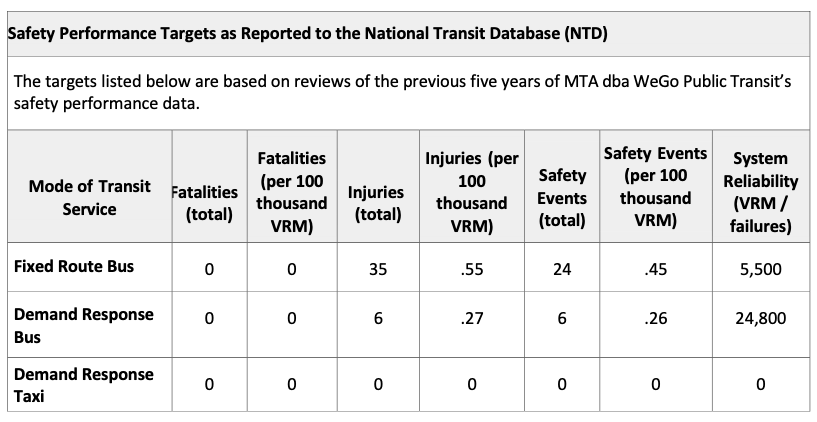

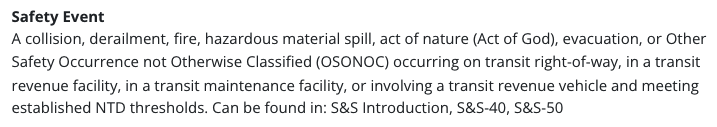

### 3.6.1 'Total Events' Column
<a id='3.6.1_Total_Events_Column'></a>
The NTD database does not have a column called 'Total Safety Events' so I will verify that the 'Toal Events' column is a total of all the events listed in the definition above from given in the [FTA Glossary](https://www.transit.dot.gov/ntd/national-transit-database-ntd-glossary).

In [3]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 26 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   5 DIgit NTD ID                         129752 non-null  int64  
 1   Agency                                 129752 non-null  object 
 2   Organization Type                      129752 non-null  object 
 3   Mode                                   129752 non-null  object 
 4   Type of Service                        129752 non-null  object 
 5   Rail (Y/N)                             129752 non-null  bool   
 6   Primary UZA Code                       129752 non-null  float64
 7   Primary UZA Name                       129752 non-null  object 
 8   Primary UZA Sq Miles                   129752 non-null  float64
 9   Primary UZA Population                 129752 non-null  float64
 10  Service Area Sq Miles                  129752 non-null  

In [4]:
#Nashville_data.info()

In [5]:
#Check to see if 'Total Events" captures all data in columns 'Total Collisions', 'Total Derailments', 'Total Fires',
#'Total Security Events', and 'Total Events Not Otherwise Classified'

National_events = National_data.iloc[:, 18:24]
Nashville_events = Nashville_data.iloc[:, 18:24]
count5 = 0
count6 = 0

for i in National_events.index:
    if sum(National_events.iloc[i,[5]]) != sum(National_events.iloc[i,0:5]):
        count5 += 1
        list5.append(i)

for i in Nashville_events.index:
    if sum(Nashville_events.iloc[i,[5]]) != sum(Nashville_events.iloc[i,0:5]):
        count5 += 1
        list5.append(i)        

print('There are ',count5, "rows where 'Total Events' does not match the sum of the other National columns")
print('There are ',count6, "rows where 'Total Events' does not match the sum of the other Nashville columns")

There are  0 rows where 'Total Events' does not match the sum of the other National columns
There are  0 rows where 'Total Events' does not match the sum of the other Nashville columns


Since the 'Total Events' column is confirmed to be the total of the other columns, I can drop the other columns from both the National and Nashville dataframes.

### 3.6.2 Drop Columns Captured by 'Total Events'
<a id='3.6.2_Drop_Columns_Captured_by_Total_Events'></a>

In [6]:
National_data.shape

(129752, 26)

In [7]:
Nashville_data.shape

(750, 26)

In [8]:
National_data = National_data.drop(National_data.iloc[:, 18:23], axis=1)
Nashville_data = Nashville_data.drop(Nashville_data.iloc[:, 18:23], axis=1)


In [9]:
National_data.shape

(129752, 21)

In [10]:
Nashville_data.shape

(750, 21)

### 3.6.5 Change Dataframes to Annual
<a id='3.6.5_Change_Dataframes_to_Annual'></a>
Since goals reported to the FTA are in annual form, I will change the rows of the dataframes to match this.  This may also help with the predictive ability of the models since agencies were permitted to report monthly VRMs as the annual expected number divided by twelve.  So, th annual numbers for that column may be more accurate than the monthly.  

In [11]:
#National_data.info()

In [12]:
#National_data.head()

In [13]:
#National_data.shape

In [14]:
#National_annual = National_data.copy()
#National_annual[['Total Fatalities Annual by Mode','Total Injuries Annual by Mode','Total Events Annual by Mode', 'Annual VRM', 'Annual Ridership']] = (National_annual.groupby(['5 DIgit NTD ID','Agency','Primary UZA Name','Mode','Year'])[['Total Fatalities', 'Total Injuries','Total Events', 'Vehicle Revenue Miles', 'Ridership']].transform('sum'))

#Nashville_annual = Nashville_data.copy()
#Nashville_annual[['Total Fatalities Annual by Mode','Total Injuries Annual by Mode','Total Events Annual by Mode', 'Annual VRM', 'Annual Ridership']] = (Nashville_data.groupby(['5 DIgit NTD ID','Agency','Primary UZA Name','Mode','Year'])[['Total Fatalities', 'Total Injuries','Total Events', 'Vehicle Revenue Miles', 'Ridership']].transform('sum'))


In [15]:
#National_annual.info()

In [16]:
#National_annual = National_annual.drop(National_annual.iloc[:, 13:21], axis=1)
#Nashville_annual = Nashville_annual.drop(Nashville_annual.iloc[:, 13:21], axis=1)

In [17]:
#National_annual.info()

In [18]:
#National_annual.head()

In [19]:
#Nashville_annual.info()

In [20]:
#Nashville_annual.sort_values(['5 DIgit NTD ID','Agency','Primary UZA Name','Mode','Type of Service','Year']).head(30)


In [21]:
#National_annual.shape

In [22]:
#National_annual = National_annual.drop_duplicates()
#Nashville_annual = Nashville_annual.drop_duplicates()

In [23]:
#National_annual.shape

In [24]:
#Nashville_annual.shape

In [25]:
#Nashville_annual.sort_values(['5 DIgit NTD ID','Agency','Primary UZA Name','Mode','Type of Service','Year']).head(30)


In [26]:
#Nashville_data[Nashville_data['Year']==2016][Nashville_data['5 DIgit NTD ID']==40004][Nashville_data['Type of Service']=='DO'].sort_values(['Mode','Month'])


### 3.6.3 Add 'Cumulative Safety per 100K VRM' Column
<a id='3.6.3_Add_Cumulative_Safety_per_100K_VRM_Column'></a>
In order to have a single column for y, I will combine the three categories of SPTs (fatalities, injuries, and events) into one and present it as a value per 100,000 VRM.  

In [27]:
National_Cumulative_Safety = (National_data['Total Fatalities'] + National_data['Total Injuries'] + National_data['Total Events'])
Nashville_Cumulative_Safety = (Nashville_data['Total Fatalities'] + Nashville_data['Total Injuries'] + Nashville_data['Total Events'])

National_data['Cumulative Safety per 100K VRM'] = (National_Cumulative_Safety/National_data['Vehicle Revenue Miles'])*100000
Nashville_data['Cumulative Safety per 100K VRM'] = (Nashville_Cumulative_Safety/Nashville_data['Vehicle Revenue Miles'])*100000


In [28]:
National_data['Cumulative Safety per 100K VRM'].isna().sum()

1185

In [29]:
Nashville_data['Cumulative Safety per 100K VRM'].isna().sum()


0

In rows where there were no fatalities, injuries, or events, I end up with Nans because I have divided by zero.  I will replace the Nans with zeros since that is the logical value.

In [30]:
National_data['Cumulative Safety per 100K VRM'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
National_data['Cumulative Safety per 100K VRM'].isna().sum()


0

In [31]:
National_data['Cumulative Safety per 100K VRM'].isna().sum()

0

In [32]:
National_data.shape

(129752, 22)

### 3.6.4 Drop Columns Accounted for in 'Cumulative Safety per 100K VRM'
<a id='3.6.4_Add_Cumulative_Safety_per_100K_VRM_Column'></a>
I can now drop the 'Total Revenue Miles', 'Total Fatalities', 'Total Injuries', and 'Total Events' columns since they are accounted for in my new 'Cumulative Safety per 100K VRM' column.

In [33]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   5 DIgit NTD ID                  129752 non-null  int64  
 1   Agency                          129752 non-null  object 
 2   Organization Type               129752 non-null  object 
 3   Mode                            129752 non-null  object 
 4   Type of Service                 129752 non-null  object 
 5   Rail (Y/N)                      129752 non-null  bool   
 6   Primary UZA Code                129752 non-null  float64
 7   Primary UZA Name                129752 non-null  object 
 8   Primary UZA Sq Miles            129752 non-null  float64
 9   Primary UZA Population          129752 non-null  float64
 10  Service Area Sq Miles           129752 non-null  float64
 11  Service Area Population         129752 non-null  float64
 12  Year            

In [34]:
National_data = National_data.drop(National_data.iloc[:, np.r_[15, 18, 19, 20]], axis=1)
Nashville_data = Nashville_data.drop(Nashville_data.iloc[:, np.r_[15, 18, 19, 20]], axis=1)

In [35]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   5 DIgit NTD ID                  129752 non-null  int64  
 1   Agency                          129752 non-null  object 
 2   Organization Type               129752 non-null  object 
 3   Mode                            129752 non-null  object 
 4   Type of Service                 129752 non-null  object 
 5   Rail (Y/N)                      129752 non-null  bool   
 6   Primary UZA Code                129752 non-null  float64
 7   Primary UZA Name                129752 non-null  object 
 8   Primary UZA Sq Miles            129752 non-null  float64
 9   Primary UZA Population          129752 non-null  float64
 10  Service Area Sq Miles           129752 non-null  float64
 11  Service Area Population         129752 non-null  float64
 12  Year            

## 3.7 Dropping Unneeded Columns
<a id='3.7_Dropping_Unneeded_Columns'></a>

**Housekeeping:** I want to take one more citical look at the columns I have left. 'Primary UZA Code' and 'Primary UZA Population' are both ordinal representations of the ranking of population size.  However, 'Primary UZA Code' has the one value (602) which is out of place.  So, 'Primary UZA Code' will be removed.

The columns 'Vehicles' and 'Vehicle Revenue Hours' will be dropped because they are too closely related to 'Vehicle Revenue Miles'.  'Month' and 'Year' will be dropped since I am not preforming time series analysis. 

I will also remove the identifier columns, '5 DIgit NTD ID', 'Agency', and 'Primary UZA Name' so that all references to location will be omitted.

In [36]:
National_data = National_data.drop(['Primary UZA Code', 'Vehicles','Vehicle Revenue Hours','Month','Year', '5 DIgit NTD ID','Agency','Primary UZA Name'], axis=1)
Nashville_data = Nashville_data.drop(['Primary UZA Code', 'Vehicles','Vehicle Revenue Hours','Month','Year', '5 DIgit NTD ID','Agency','Primary UZA Name'], axis=1)


In [37]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Organization Type               129752 non-null  object 
 1   Mode                            129752 non-null  object 
 2   Type of Service                 129752 non-null  object 
 3   Rail (Y/N)                      129752 non-null  bool   
 4   Primary UZA Sq Miles            129752 non-null  float64
 5   Primary UZA Population          129752 non-null  float64
 6   Service Area Sq Miles           129752 non-null  float64
 7   Service Area Population         129752 non-null  float64
 8   Ridership                       129752 non-null  int64  
 9   Cumulative Safety per 100K VRM  129752 non-null  float64
dtypes: bool(1), float64(5), int64(1), object(3)
memory usage: 9.0+ MB


## 3.8 Encoding the Categorical Features
<a id= '3.8_Encoding_the_Categorical_Features'></a>
Time to encode the categorical variables

In [38]:
National_data['Organization Type'].value_counts()

Independent Public Agency or Authority of Transit Service                68469
City, County or Local Government Unit or Department of Transportation    46395
MPO, COG or Other Planning Agency                                         2790
State Government Unit or Department of Transportation                     2304
Other Publicly-Owned or Privately Chartered Corporation                   1918
Subsidiary Unit of a Transit Agency, Reporting Separately                 1866
Private-Non-Profit Corporation                                            1721
Private-For-Profit Corporation                                            1573
University                                                                1278
Private Provider Reporting on Behalf of a Public Entity                   1180
Other                                                                      132
Consolidated Reporter                                                      126
Name: Organization Type, dtype: int64

In [39]:
#Renaming the Organization Types so the dummied column names won't be so cumbersome

National_data['Organization Type'] = National_data['Organization Type'].map({
    'Independent Public Agency or Authority of Transit Service' : 'A',
    'Subsidiary Unit of a Transit Agency, Reporting Separately' : 'F',
    'City, County or Local Government Unit or Department of Transportation': 'B',
    'University': 'I',
    'Consolidated Reporter': 'L',
    'Other': 'K',
    'Private-For-Profit Corporation': 'H',
    'Private Provider Reporting on Behalf of a Public Entity': 'J',
    'MPO, COG or Other Planning Agency': 'C',
    'State Government Unit or Department of Transportation': 'D',
    'Private-Non-Profit Corporation': 'G',
    'Other Publicly-Owned or Privately Chartered Corporation': 'E'})


In [40]:
Nashville_data['Organization Type'].unique()

array(['Private Provider Reporting on Behalf of a Public Entity',
       'Independent Public Agency or Authority of Transit Service'],
      dtype=object)

In [41]:
Nashville_data['Organization Type'] = Nashville_data['Organization Type'].map({
    'Independent Public Agency or Authority of Transit Service' : 'A',
    'Private Provider Reporting on Behalf of a Public Entity': 'J',})


In [42]:
National_data['Organization Type'].value_counts()

A    68469
B    46395
C     2790
D     2304
E     1918
F     1866
G     1721
H     1573
I     1278
J     1180
K      132
L      126
Name: Organization Type, dtype: int64

In [43]:
Nashville_data['Organization Type'].value_counts()

A    648
J    102
Name: Organization Type, dtype: int64

In [44]:
National_data = pd.get_dummies(National_data, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])
Nashville_data = pd.get_dummies(Nashville_data, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])

In [45]:
National_data.shape

(129752, 37)

In [46]:
Nashville_data.shape

(750, 17)

In [47]:
# Change dtype of 'Rail (Y/N)'
National_data['Rail (Y/N)'] = National_data['Rail (Y/N)'].astype(np.uint8)
Nashville_data['Rail (Y/N)'] = Nashville_data['Rail (Y/N)'].astype(np.uint8)


In [48]:
National_data = National_data[National_data['Ridership'] != 0]
Nashville_data = Nashville_data[Nashville_data['Ridership'] != 0]


In [49]:
National_data.shape

(128508, 37)

In [50]:
Nashville_data.shape

(750, 17)

In [51]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128508 entries, 0 to 129751
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Rail (Y/N)                      128508 non-null  uint8  
 1   Primary UZA Sq Miles            128508 non-null  float64
 2   Primary UZA Population          128508 non-null  float64
 3   Service Area Sq Miles           128508 non-null  float64
 4   Service Area Population         128508 non-null  float64
 5   Ridership                       128508 non-null  int64  
 6   Cumulative Safety per 100K VRM  128508 non-null  float64
 7   M_CB                            128508 non-null  uint8  
 8   M_CC                            128508 non-null  uint8  
 9   M_CR                            128508 non-null  uint8  
 10  M_DR                            128508 non-null  uint8  
 11  M_HR                            128508 non-null  uint8  
 12  M_LR            

In [52]:
Nashville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rail (Y/N)                      750 non-null    uint8  
 1   Primary UZA Sq Miles            750 non-null    float64
 2   Primary UZA Population          750 non-null    float64
 3   Service Area Sq Miles           750 non-null    float64
 4   Service Area Population         750 non-null    float64
 5   Ridership                       750 non-null    int64  
 6   Cumulative Safety per 100K VRM  750 non-null    float64
 7   M_CB                            750 non-null    uint8  
 8   M_CR                            750 non-null    uint8  
 9   M_DR                            750 non-null    uint8  
 10  M_MB                            750 non-null    uint8  
 11  M_VP                            750 non-null    uint8  
 12  OT_A                            750 

## 3.9 Exploring the Data
<a id= '3.9_Exploring_the_Data'></a>
I'll take a new look at the statistics and relationships since the target and features are now clearly defined.

In [53]:
National_data.describe()

Rail (Y/N)  Primary UZA Sq Miles  Primary UZA Population  \
count  128508.000000         128508.000000            1.285080e+05   
mean        0.073739            666.644785            2.495853e+06   
std         0.261346            845.721673            4.259405e+06   
min         0.000000             11.000000            5.124000e+04   
25%         0.000000             92.000000            2.091900e+05   
50%         0.000000            296.000000            6.159680e+05   
75%         0.000000            905.000000            2.650890e+06   
max         1.000000           3450.000000            1.835130e+07   

       Service Area Sq Miles  Service Area Population     Ridership  \
count          128508.000000             1.285080e+05  1.285080e+05   
mean              662.248296             1.004593e+06  5.529512e+05   
std              1275.168078             1.811300e+06  6.008297e+06   
min                 1.000000             1.000000e+00  1.000000e+00   
25%                75.000000             1.548550e+05  4.767750e+03   
50%               251.000000             3.417415e+05  2.056700e+04   
75%               683.000000             9.356140e+05  1.245040e+05   
max             15355.000000             1.835130e+07  2.536099e+08   

       Cumulative Safety per 100K VRM           M_CB           M_CC  \
count                   128508.000000  128508.000000  128508.000000   
mean                         0.355762       0.072657       0.000584   
std                          3.072057       0.259574       0.024151   
min                          0.000000       0.000000       0.000000   
25%                          0.000000       0.000000       0.000000   
50%                          0.000000       0.000000       0.000000   
75%                          0.000000       0.000000       0.000000   
max                        609.756098       1.000000       1.000000   

                M_CR  ...           OT_G           OT_H           OT_I  \
count  128508.000000  ...  128508.000000  128508.000000  128508.000000   
mean        0.020699  ...       0.013252       0.012085       0.009190   
std         0.142376  ...       0.114353       0.109265       0.095424   
min         0.000000  ...       0.000000       0.000000       0.000000   
25%         0.000000  ...       0.000000       0.000000       0.000000   
50%         0.000000  ...       0.000000       0.000000       0.000000   
75%         0.000000  ...       0.000000       0.000000       0.000000   
max         1.000000  ...       1.000000       1.000000       1.000000   

                OT_J           OT_K           OT_L         ToS_DO  \
count  128508.000000  128508.000000  128508.000000  128508.000000   
mean        0.009136       0.001027       0.000980       0.521617   
std         0.095143       0.032033       0.031297       0.499534   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       0.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

              ToS_PT         ToS_TN         ToS_TX  
count  128508.000000  128508.000000  128508.000000  
mean        0.426168       0.001587       0.050627  
std         0.494521       0.039811       0.219236  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         1.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000  

[8 rows x 37 columns]

In [54]:
Nashville_data.describe()

Rail (Y/N)  Primary UZA Sq Miles  Primary UZA Population  \
count  750.000000                 750.0                   750.0   
mean     0.136000                 563.0                969587.0   
std      0.343017                   0.0                     0.0   
min      0.000000                 563.0                969587.0   
25%      0.000000                 563.0                969587.0   
50%      0.000000                 563.0                969587.0   
75%      0.000000                 563.0                969587.0   
max      1.000000                 563.0                969587.0   

       Service Area Sq Miles  Service Area Population      Ridership  \
count             750.000000             7.500000e+02     750.000000   
mean             1494.856000             1.216144e+06  102767.350667   
std              2307.369812             5.123273e+05  232536.958736   
min               484.000000             6.266810e+05     872.000000   
25%               484.000000             6.912430e+05    7704.500000   
50%               750.000000             1.583115e+06   14657.000000   
75%               750.000000             1.583115e+06   25214.000000   
max              7505.000000             1.978890e+06  899840.000000   

       Cumulative Safety per 100K VRM        M_CB        M_CR        M_DR  \
count                      750.000000  750.000000  750.000000  750.000000   
mean                         0.219111    0.184000    0.136000    0.272000   
std                          1.084786    0.387743    0.343017    0.445287   
min                          0.000000    0.000000    0.000000    0.000000   
25%                          0.000000    0.000000    0.000000    0.000000   
50%                          0.000000    0.000000    0.000000    0.000000   
75%                          0.000000    0.000000    0.000000    1.000000   
max                         21.978900    1.000000    1.000000    1.000000   

             M_MB        M_VP        OT_A        OT_J      ToS_DO      ToS_PT  \
count  750.000000  750.000000  750.000000  750.000000  750.000000  750.000000   
mean     0.136000    0.272000    0.864000    0.136000    0.456000    0.408000   
std      0.343017    0.445287    0.343017    0.343017    0.498393    0.491791   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
75%      0.000000    1.000000    1.000000    0.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           ToS_TX  
count  750.000000  
mean     0.136000  
std      0.343017  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

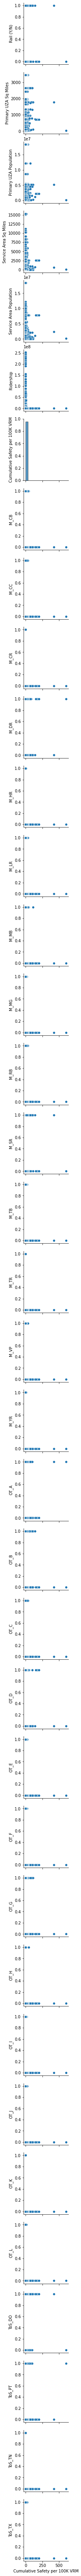

In [55]:

sns.pairplot(
    National_data,
    x_vars=['Cumulative Safety per 100K VRM'],
    y_vars=National_data.iloc[:, np.r_[0:6,6:37]],
)


<AxesSubplot:>

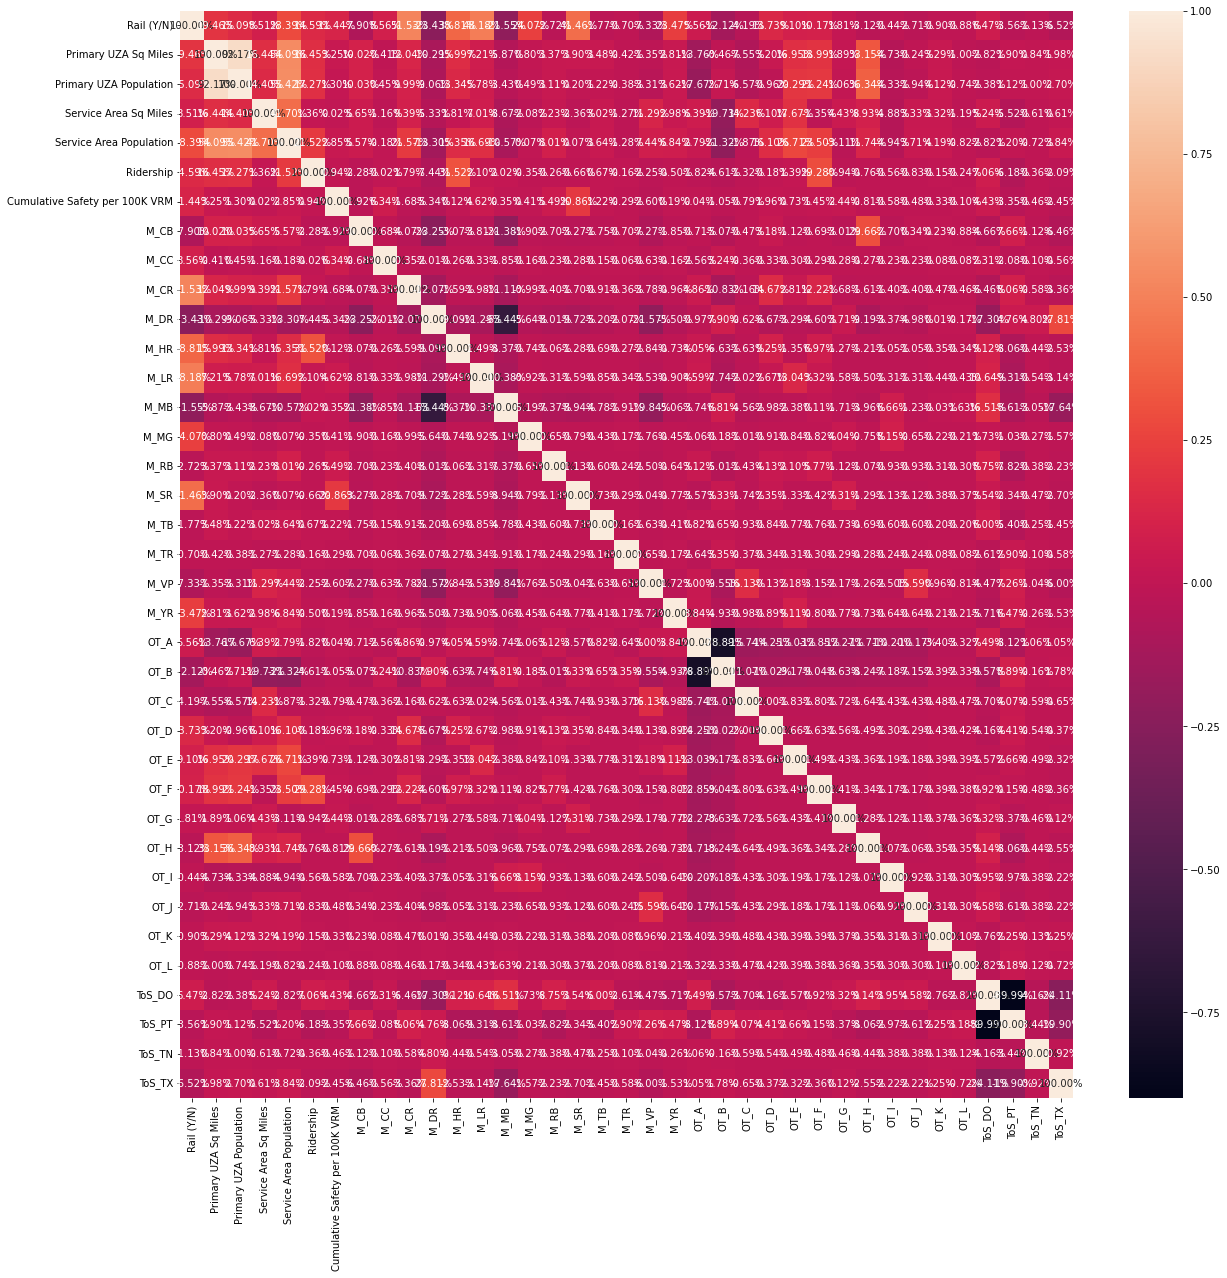

In [56]:
plt.subplots(figsize=(20,20))
sns.heatmap(National_data.corr(), annot=True, fmt='.2%')

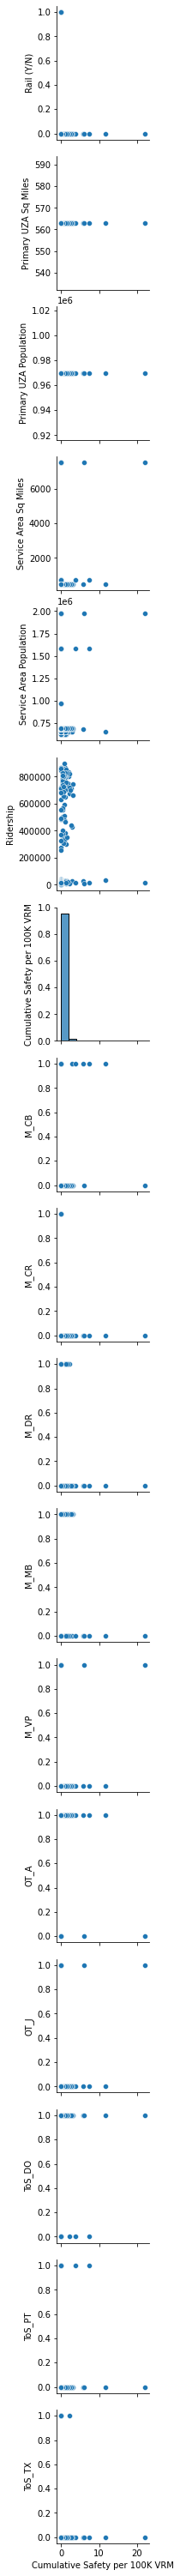

In [57]:
sns.pairplot(
    Nashville_data,
    x_vars=['Cumulative Safety per 100K VRM'],
    y_vars=Nashville_data.iloc[:, np.r_[0:6,6:17]],
)

<AxesSubplot:>

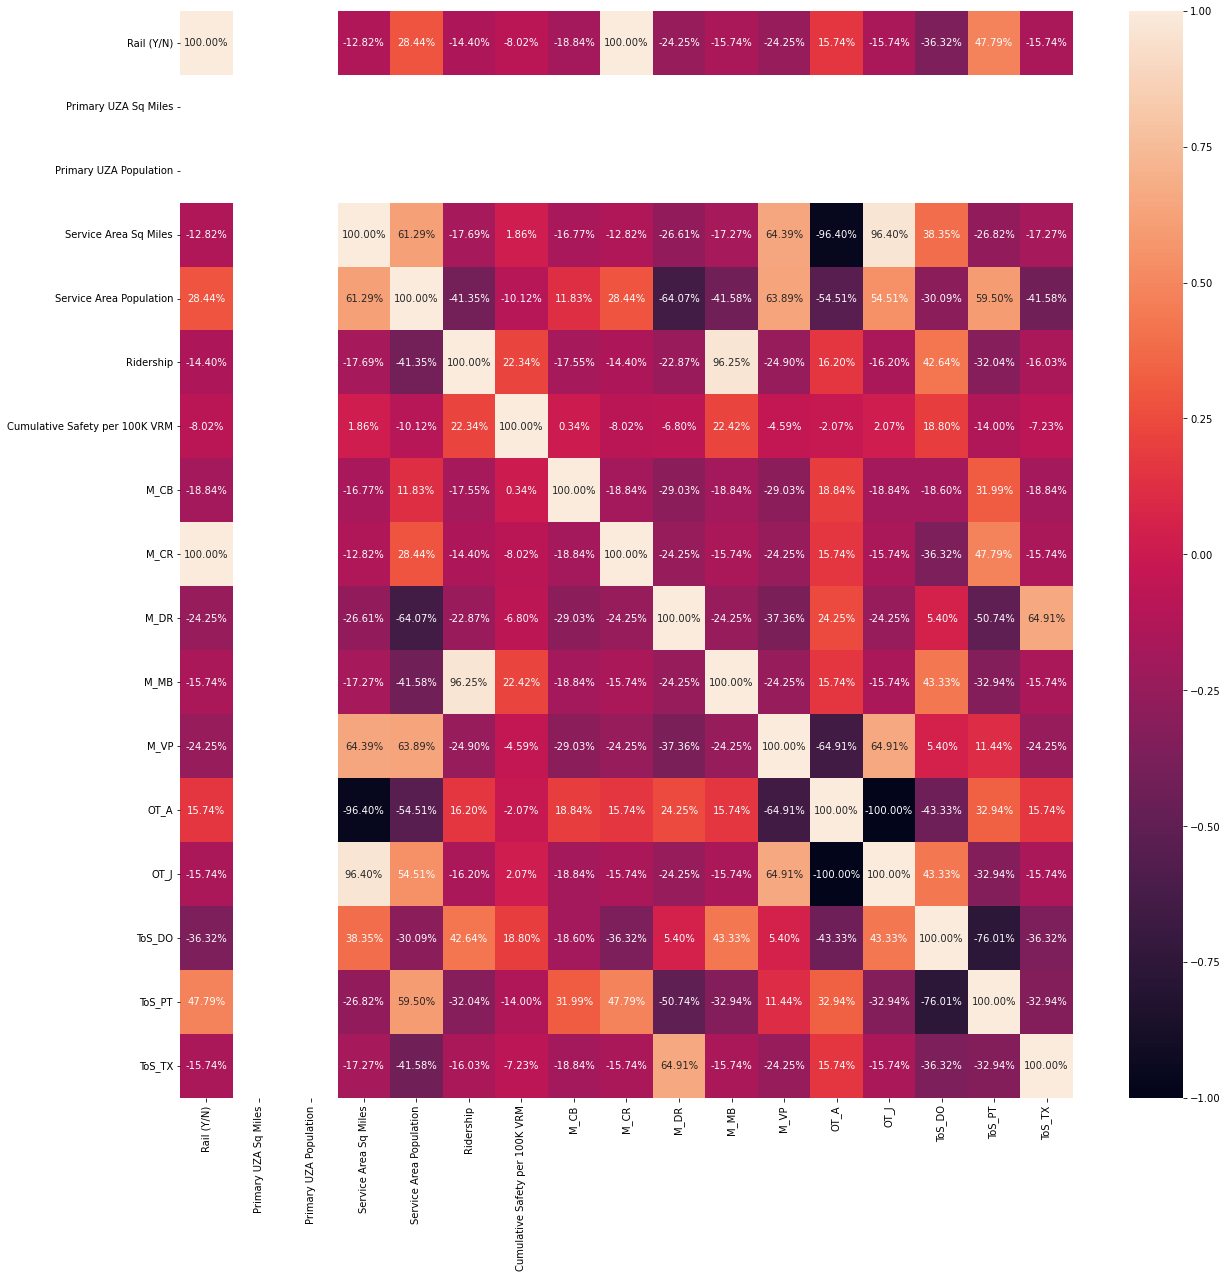

In [58]:
plt.subplots(figsize=(20,20))
sns.heatmap(Nashville_data.corr(), annot=True, fmt='.2%')

## 3.10 Train/Test Split
<a id= 'Train_Test_Split'></a>

In [59]:
#Defining X and y from National_data

X_National = National_data.drop(['Cumulative Safety per 100K VRM'], axis = 1)
y_National = National_data['Cumulative Safety per 100K VRM']

In [60]:
# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(X_National, y_National, test_size=0.2)
#X_train.info()

## 3.11 Linear Regression
<a id= '3.11_Linear_Regression'></a>
I would not expect linear regression to work well because of the number of discrete variables in the dataset, but I will try it anyway.

In [61]:
Model_lr = LinearRegression()

In [62]:
Model_lr.fit(X_train, y_train)

LinearRegression()

In [63]:
y_pred_lr = Model_lr.predict(X_test)

Text(0, 0.5, 'predicted')

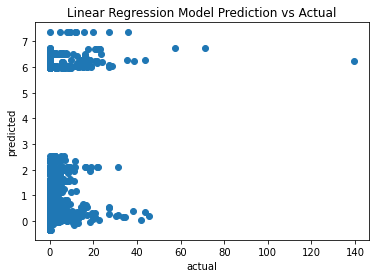

In [64]:
# Evaluate performance

plt.scatter(y_test, y_pred_lr)

plt.title("Linear Regression Model Prediction vs Actual")
plt.xlabel('actual')
plt.ylabel('predicted')

As expected, linear regression is not a good choice.

## 3.12 Random Forest
<a id= '3.12_Random_Forest'></a>

In [65]:
Model_rf = RandomForestRegressor()

In [66]:
Model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [67]:
y_pred_rf = Model_rf.predict(X_test)

Text(0, 0.5, 'predicted')

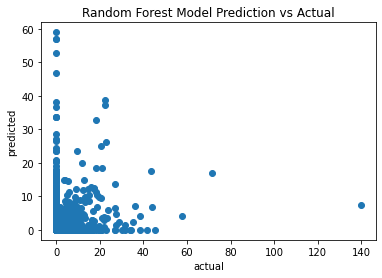

In [68]:
# Evaluate performance

plt.scatter(y_test, y_pred_rf)

plt.title("Random Forest Model Prediction vs Actual")
plt.xlabel('actual')
plt.ylabel('predicted')

In [69]:
# Trying a scaled model to see if that improves model performance

Model_rf_pipe = make_pipeline(StandardScaler(), RandomForestRegressor())

In [70]:
Model_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [71]:
y_pred_rf_pipe = Model_rf_pipe.predict(X_test)

Text(0, 0.5, 'predicted')

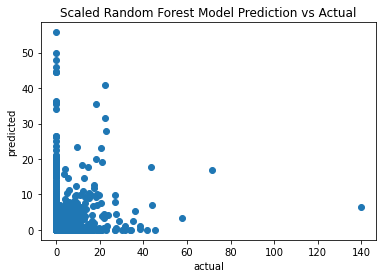

In [72]:
# Evaluate performance

plt.scatter(y_test, y_pred_rf_pipe)

plt.title("Scaled Random Forest Model Prediction vs Actual")
plt.xlabel('actual')
plt.ylabel('predicted')

## 3.13 KNN
<a id= '3.13_KNN'></a>

In [73]:
Model_knn = KNeighborsRegressor()

In [74]:
Model_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [75]:
y_pred_knn = Model_knn.predict(X_test)

Text(0, 0.5, 'predicted')

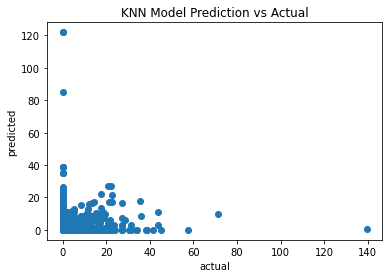

In [76]:
# Evaluate performance

plt.scatter(y_test, y_pred_knn)

plt.title("KNN Model Prediction vs Actual")
plt.xlabel('actual')
plt.ylabel('predicted')

In [77]:
# Trying a scaled model to see if that improves model performance

Model_knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

In [78]:
Model_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

In [79]:
y_pred_knn_pipe = Model_knn_pipe.predict(X_test)

Text(0, 0.5, 'predicted')

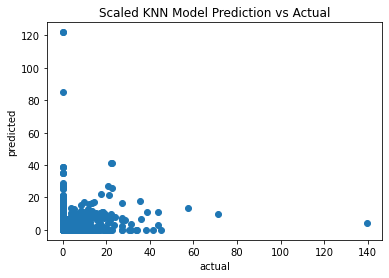

In [80]:
# Evaluate performance

plt.scatter(y_test, y_pred_knn_pipe)

plt.title("Scaled KNN Model Prediction vs Actual")
plt.xlabel('actual')
plt.ylabel('predicted')